<a href="https://colab.research.google.com/github/Dewdiii/Forecasting-Industry-Growth-Based-on-Historical-Trade-Data-Exports-Imports-in-Sri-Lanka./blob/main/ImpExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os, pickle
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [54]:
from google.colab import files
uploaded = files.upload()  # Choose ImpExp.zip

Saving ImpExp.zip to ImpExp (1).zip


In [55]:
import zipfile
import os

with zipfile.ZipFile("ImpExp.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  # extracts to data/ImpExp/

In [56]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [57]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_industry_data(industry):
    # List all .xlsx files inside the industry-specific folder
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [os.path.join(data_dir.format(industry), f) for f in all_csvs]

    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(csv, sheet_name='Partner')
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, f"More than one or no 'World' data found in {csv}"

        df = df[[
            'Year',
            'Export (US$ Thousand)',
            'Import (US$ Thousand)',
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)',
        ]]
        df.reset_index(drop=True, inplace=True)
        all_data.append(df)

    # Combine all files
    all_data = pd.concat(all_data).reset_index(drop=True)

    # Fill missing values with column means
    all_data.fillna(all_data.mean(), inplace=True)
    all_data = all_data.astype(float)

    # Sort by year and remove the 'Year' column
    all_data.sort_values(by='Year', inplace=True)
    all_data.drop(columns=['Year'], inplace=True)

    # Fit and save the scaler
    scaler = StandardScaler()
    scaler.fit(all_data)

    # Create model directory if it doesn't exist
    os.makedirs(os.path.dirname(model_dir.format("")), exist_ok=True)

    with open(model_dir.format(f"{industry} Scalar.pickle"), 'wb') as f:
        pickle.dump(scaler, f)

    # Scale the data
    scaled_data = pd.DataFrame(scaler.transform(all_data), columns=all_data.columns)
    return scaled_data

def make_ts_dataset(industry, selective_window=7):
    df = load_industry_data(industry)

    X, Y1, Y2 = [], [], []
    for i in range(len(df) - selective_window):
        x = df.iloc[i:i+selective_window].values
        y1 = df.iloc[i+selective_window, 0]  # Export
        y2 = df.iloc[i+selective_window, 1]  # Import

        X.append(x)
        Y1.append(y1)
        Y2.append(y2)

    return np.array(X), np.array(Y1), np.array(Y2)


### Load Sample Data

In [58]:
X, Y1, Y2 = make_ts_dataset('Agricultural Raw Materials')

print("World Data Shape : ", X.shape)
print("Export Data Shape : ", Y1.shape)
print("Import Data Shape : ", Y2.shape)

World Data Shape :  (9, 7, 7)
Export Data Shape :  (9,)
Import Data Shape :  (9,)


**Splitting dataset**

In [59]:
def train_test_split_ts(X, Y1, Y2, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], Y1[:split_index], Y1[split_index:], Y2[:split_index], Y2[split_index:]

# Use the functions
X, Y1, Y2 = make_ts_dataset("Agricultural Raw Materials", selective_window=7)
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split_ts(X, Y1, Y2)

## Build, Train, Evaluate model

**Baseline model**

**ARIMA**

In [60]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def train_arima_model(train, test, title='', plot=False):
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()

    predictions = model_fit.forecast(steps=len(test))

    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)

    print(title + " - ARIMA MSE: %.4f" % mse)
    print(title + " - ARIMA MAE: %.4f" % mae)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(range(len(train)), train, label='Train')
        plt.plot(range(len(train), len(train) + len(test)), test, label='Test', color='orange')
        plt.plot(range(len(train), len(train) + len(test)), predictions, label='ARIMA Predictions', color='green')
        plt.title(title + ' - ARIMA Forecast')
        plt.legend()
        plt.show()

    return mse, mae

In [61]:
def run_arima_model(industry):
    _, Y1, Y2 = make_ts_dataset(industry)

    # Flatten because ARIMA needs 1D
    Y1 = Y1.flatten()
    Y2 = Y2.flatten()

    # Simple 80/20 split
    split_idx = int(len(Y1) * 0.8)
    Y1_train, Y1_test = Y1[:split_idx], Y1[split_idx:]
    Y2_train, Y2_test = Y2[:split_idx], Y2[split_idx:]

    imp_mse, imp_mae = train_arima_model(Y2_train, Y2_test, title=f'{industry} Import')
    exp_mse, exp_mae = train_arima_model(Y1_train, Y1_test, title=f'{industry} Export')

    return {
        "Imp_MSE": imp_mse,
        "Imp_MAE": imp_mae,
        "Exp_MSE": exp_mse,
        "Exp_MAE": exp_mae
    }

In [62]:
results_arima = run_arima_model("Agricultural Raw Materials")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Agricultural Raw Materials Import - ARIMA MSE: 2.3144
Agricultural Raw Materials Import - ARIMA MAE: 1.5085
Agricultural Raw Materials Export - ARIMA MSE: 0.2558
Agricultural Raw Materials Export - ARIMA MAE: 0.4994


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
results_arima = run_arima_model("Consumer Goods")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Consumer Goods Import - ARIMA MSE: 0.2107
Consumer Goods Import - ARIMA MAE: 0.3792
Consumer Goods Export - ARIMA MSE: 0.2559
Consumer Goods Export - ARIMA MAE: 0.4986


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
results_arima = run_arima_model("Transportation")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Transportation Import - ARIMA MSE: 1.7048
Transportation Import - ARIMA MAE: 1.1533
Transportation Export - ARIMA MSE: 1.5955
Transportation Export - ARIMA MAE: 0.9755


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
results_arima = run_arima_model("Food Industry")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Food Industry Import - ARIMA MSE: 0.2079
Food Industry Import - ARIMA MAE: 0.4417
Food Industry Export - ARIMA MSE: 0.0754
Food Industry Export - ARIMA MAE: 0.2665


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [66]:
results_arima = run_arima_model("Capital Goods")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Capital Goods Import - ARIMA MSE: 0.6969
Capital Goods Import - ARIMA MAE: 0.7041
Capital Goods Export - ARIMA MSE: 0.9875
Capital Goods Export - ARIMA MAE: 0.9430


**Advanced Models**

**LSTM**

In [67]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

def build_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )
    return model

def train_lstm_model(industry, epochs=100, batch_size=4):
    X, Y1, Y2 = make_ts_dataset(industry)

    # Same 80/20 split
    X_train, X_test, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.2, random_state=42)
    _, _, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)

    print(f"................ Training LSTM on : {industry} ................")
    model_imp = build_lstm_model()
    model_exp = build_lstm_model()

    history_imp = model_imp.fit(
        X_train, Y1_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y1_test)
    )

    history_exp = model_exp.fit(
        X_train, Y2_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y2_test)
    )

    model_imp.save(model_dir.format(f"{industry} LSTM_Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} LSTM_Exp.h5"))

    # Evaluate on test data
    imp_test_loss, imp_test_mae = model_imp.evaluate(X_test, Y1_test, verbose=0)
    exp_test_loss, exp_test_mae = model_exp.evaluate(X_test, Y2_test, verbose=0)

    print(f"LSTM Import Model Test MAE: {imp_test_mae:.4f}, MSE: {imp_test_loss:.4f}")
    print(f"LSTM Export Model Test MAE: {exp_test_mae:.4f}, MSE: {exp_test_loss:.4f}")

    return history_imp, history_exp, imp_test_loss, imp_test_mae, exp_test_loss, exp_test_mae

def plot_lstm_loss(industry, history_imp, history_exp):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='Train Loss (MSE)')
    plt.plot(history_imp.history['val_loss'], label='Val Loss (MSE)')
    plt.plot(history_imp.history['mae'], label='Train MAE')
    plt.plot(history_imp.history['val_mae'], label='Val MAE')
    plt.title("Import Model Loss & MAE")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='Train Loss (MSE)')
    plt.plot(history_exp.history['val_loss'], label='Val Loss (MSE)')
    plt.plot(history_exp.history['mae'], label='Train MAE')
    plt.plot(history_exp.history['val_mae'], label='Val MAE')
    plt.title("Export Model Loss & MAE")
    plt.legend()

    plt.suptitle(f"{industry} LSTM Model Training & Validation Metrics")
    plt.show()

def run_lstm_model(industry):
    history_imp, history_exp, imp_loss, imp_mae, exp_loss, exp_mae = train_lstm_model(industry)
    plot_lstm_loss(industry, history_imp, history_exp)
    return {
        "Imp_MSE": imp_loss,
        "Imp_MAE": imp_mae,
        "Exp_MSE": exp_loss,
        "Exp_MAE": exp_mae
    }

................ Training LSTM on : Agricultural Raw Materials ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step - loss: 0.6006 - mae: 0.5157 - val_loss: 0.4158 - val_mae: 0.5127
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.4472 - mae: 0.4480 - val_loss: 0.2434 - val_mae: 0.3709
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.3603 - mae: 0.4470 - val_loss: 0.1350 - val_mae: 0.2838
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2706 - mae: 0.4060 - val_loss: 0.0595 - val_mae: 0.2103
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1857 - mae: 0.3546 - val_loss: 0.0190 - val_mae: 0.1379
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1104 - mae: 0.2803 - val_loss: 0.0278 - val_mae: 0.1566
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0620 - mae: 0.2176 - val_loss: 0.0885 - val_mae: 0.2975
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0513 - mae: 0.1660 - val_loss: 0.1652 - val_mae

LSTM Import Model Test MAE: 0.3720, MSE: 0.1804
LSTM Export Model Test MAE: 0.4927, MSE: 0.2437


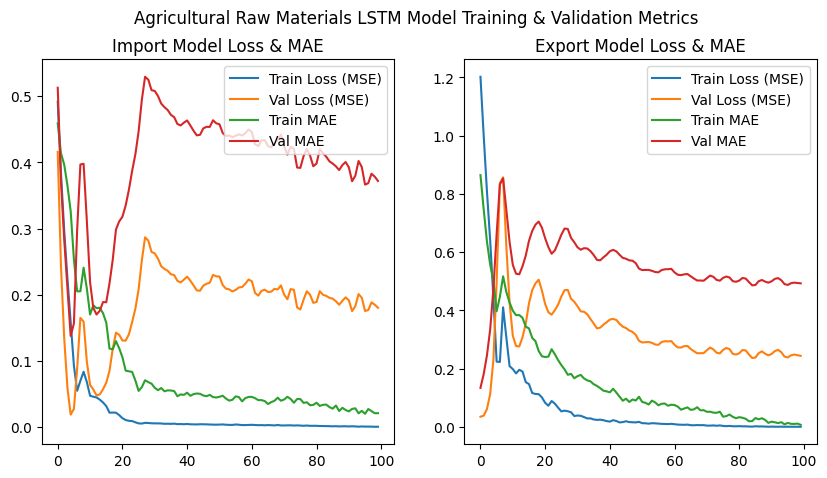

{'Imp_MSE': 0.18041624128818512,
 'Imp_MAE': 0.3719857931137085,
 'Exp_MSE': 0.2437249720096588,
 'Exp_MAE': 0.4926659166812897}

In [68]:
run_lstm_model("Agricultural Raw Materials")

................ Training LSTM on : Consumer Goods ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - loss: 0.9681 - mae: 0.8471 - val_loss: 0.1920 - val_mae: 0.4380
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.6838 - mae: 0.7576 - val_loss: 0.1638 - val_mae: 0.3737
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.6235 - mae: 0.7102 - val_loss: 0.1966 - val_mae: 0.3393
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.4273 - mae: 0.6093 - val_loss: 0.3078 - val_mae: 0.5307
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2371 - mae: 0.4454 - val_loss: 0.4428 - val_mae: 0.6654
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1208 - mae: 0.2634 - val_loss: 0.5831 - val_mae: 0.7334
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0648 - mae: 0.1633 - val_loss: 0.5957 - val_mae: 0.6657
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0553 - mae: 0.1900 - val_loss: 0.4315 - val_mae: 0.4792
Ep

LSTM Import Model Test MAE: 0.5059, MSE: 0.3157
LSTM Export Model Test MAE: 0.5621, MSE: 0.4376


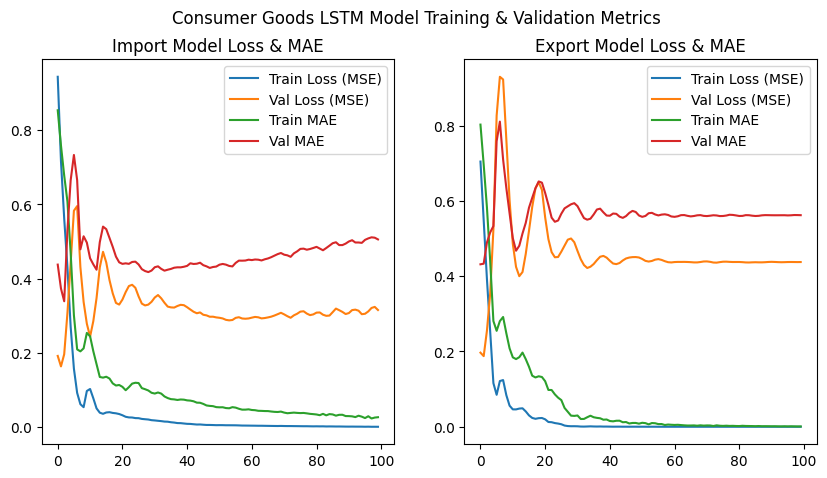

{'Imp_MSE': 0.315681129693985,
 'Imp_MAE': 0.5058724880218506,
 'Exp_MSE': 0.4376158118247986,
 'Exp_MAE': 0.5620805025100708}

In [69]:
run_lstm_model('Consumer Goods')

................ Training LSTM on : Transportation ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 589ms/step - loss: 1.9662 - mae: 0.9431 - val_loss: 0.4522 - val_mae: 0.6713
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.9045 - mae: 0.5125 - val_loss: 0.5545 - val_mae: 0.7432
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 1.5650 - mae: 0.7898 - val_loss: 0.7007 - val_mae: 0.8361
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.6875 - mae: 0.4692 - val_loss: 0.8731 - val_mae: 0.9336
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.1709 - mae: 0.7527 - val_loss: 1.1395 - val_mae: 1.0660
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.6402 - mae: 0.6064 - val_loss: 1.4648 - val_mae: 1.2035
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.5326 - mae: 0.6105 - val_loss: 1.8659 - val_mae: 1.3562
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.6958 - mae: 0.7354 - val_loss: 2.1314 - val_mae: 1.4521
E

LSTM Import Model Test MAE: 0.6850, MSE: 0.4700
LSTM Export Model Test MAE: 0.4279, MSE: 0.1849


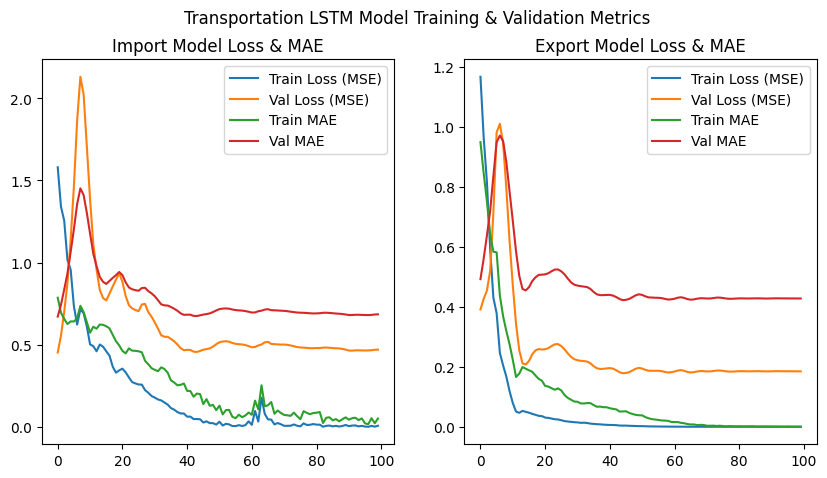

{'Imp_MSE': 0.4700082838535309,
 'Imp_MAE': 0.6849734783172607,
 'Exp_MSE': 0.1849207580089569,
 'Exp_MAE': 0.42794501781463623}

In [70]:
run_lstm_model('Transportation')

................ Training LSTM on : Food Industry ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step - loss: 0.7573 - mae: 0.5879 - val_loss: 0.6056 - val_mae: 0.5957
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.7282 - mae: 0.6400 - val_loss: 0.3528 - val_mae: 0.4413
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7407 - mae: 0.6005 - val_loss: 0.1371 - val_mae: 0.3451
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2557 - mae: 0.3936 - val_loss: 0.0512 - val_mae: 0.1832
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2795 - mae: 0.3915 - val_loss: 0.2455 - val_mae: 0.4933
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1309 - mae: 0.3354 - val_loss: 0.6310 - val_mae: 0.7452
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2153 - mae: 0.4386 - val_loss: 0.7164 - val_mae: 0.7561
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1741 - mae: 0.3845 - val_loss: 0.4074 - val_mae: 0.5650
Epo

LSTM Import Model Test MAE: 0.3858, MSE: 0.2623
LSTM Export Model Test MAE: 0.3462, MSE: 0.2276


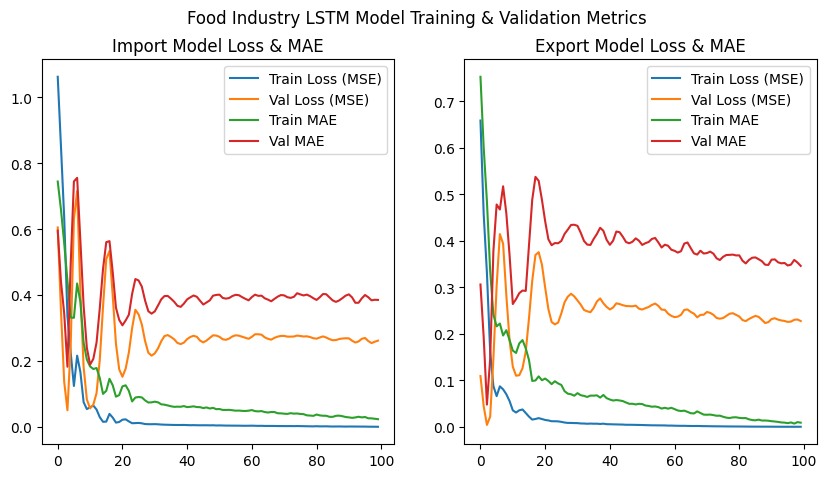

{'Imp_MSE': 0.26226934790611267,
 'Imp_MAE': 0.38581618666648865,
 'Exp_MSE': 0.22758513689041138,
 'Exp_MAE': 0.3462367057800293}

In [71]:
run_lstm_model('Food Industry')

................ Training LSTM on : Capital Goods ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 717ms/step - loss: 1.2602 - mae: 0.9482 - val_loss: 0.0404 - val_mae: 0.2011
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 1.0489 - mae: 0.8862 - val_loss: 0.0199 - val_mae: 0.1160
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.6322 - mae: 0.6656 - val_loss: 0.0368 - val_mae: 0.1870
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.4283 - mae: 0.5527 - val_loss: 0.1096 - val_mae: 0.3295
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.4209 - mae: 0.5636 - val_loss: 0.2898 - val_mae: 0.5173
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2298 - mae: 0.4400 - val_loss: 0.6165 - val_mae: 0.7454
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1370 - mae: 0.3064 - val_loss: 0.9466 - val_mae: 0.9505
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1772 - mae: 0.2781 - val_loss: 1.0008 - val_mae: 0.995

LSTM Import Model Test MAE: 0.5690, MSE: 0.3248
LSTM Export Model Test MAE: 0.4282, MSE: 0.2908


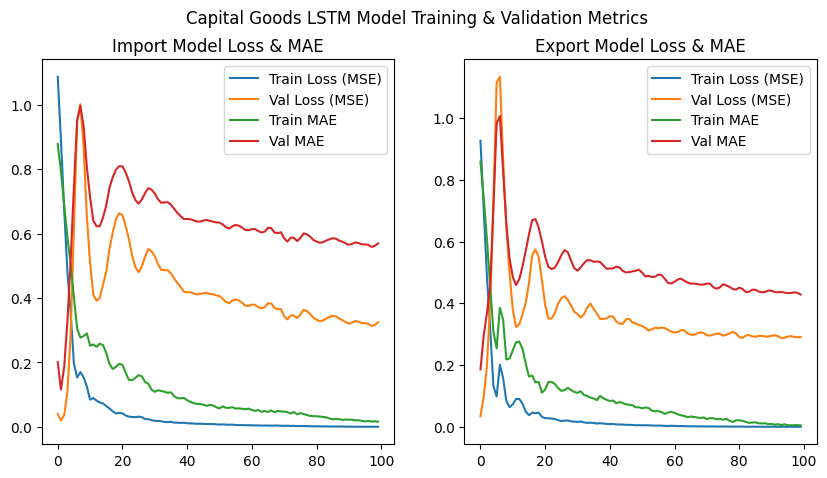

{'Imp_MSE': 0.3247557580471039,
 'Imp_MAE': 0.5690479278564453,
 'Exp_MSE': 0.2907869517803192,
 'Exp_MAE': 0.4281812012195587}

In [72]:
run_lstm_model('Capital Goods')

**GRU**

In [73]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

def build_gru_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )
    return model

def train_gru_model(industry, epochs=100, batch_size=4):
    X, Y1, Y2 = make_ts_dataset(industry)

    # Split dataset 80% train, 20% test
    X_train, X_test, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.2, random_state=42)
    _, _, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)

    print(f"................ Training GRU on : {industry} ................")
    model_imp = build_gru_model()
    model_exp = build_gru_model()

    history_imp = model_imp.fit(
        X_train, Y1_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y1_test),
        verbose=1  # print each epoch
    )

    history_exp = model_exp.fit(
        X_train, Y2_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y2_test),
        verbose=1  # print each epoch
    )

    model_imp.save(model_dir.format(f"{industry} GRU_Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} GRU_Exp.h5"))

    # Evaluate on test set
    imp_mse, imp_mae = model_imp.evaluate(X_test, Y1_test, verbose=0)
    exp_mse, exp_mae = model_exp.evaluate(X_test, Y2_test, verbose=0)

    print(f"GRU Import Model Test MAE: {imp_mae:.4f}, MSE: {imp_mse:.4f}")
    print(f"GRU Export Model Test MAE: {exp_mae:.4f}, MSE: {exp_mse:.4f}")

    return history_imp, history_exp, imp_mse, imp_mae, exp_mse, exp_mae

def plot_gru_loss(industry, history_imp, history_exp):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='Train Loss (MSE)')
    plt.plot(history_imp.history['val_loss'], label='Val Loss (MSE)')
    plt.plot(history_imp.history['mae'], label='Train MAE')
    plt.plot(history_imp.history['val_mae'], label='Val MAE')
    plt.title("Import Model Loss & MAE")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='Train Loss (MSE)')
    plt.plot(history_exp.history['val_loss'], label='Val Loss (MSE)')
    plt.plot(history_exp.history['mae'], label='Train MAE')
    plt.plot(history_exp.history['val_mae'], label='Val MAE')
    plt.title("Export Model Loss & MAE")
    plt.legend()

    plt.suptitle(f"{industry} GRU Model Training & Validation Metrics")
    plt.show()

def run_gru_model(industry):
    history_imp, history_exp, imp_mse, imp_mae, exp_mse, exp_mae = train_gru_model(industry)
    plot_gru_loss(industry, history_imp, history_exp)
    return {
        "Imp_MAE": imp_mae,
        "Imp_MSE": imp_mse,
        "Exp_MAE": exp_mae,
        "Exp_MSE": exp_mse
    }


................ Training GRU on : Agricultural Raw Materials ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - loss: 0.4557 - mae: 0.4406 - val_loss: 0.1444 - val_mae: 0.3440
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.2677 - mae: 0.4138 - val_loss: 0.0659 - val_mae: 0.2564
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1626 - mae: 0.3576 - val_loss: 0.0766 - val_mae: 0.2701
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1023 - mae: 0.2814 - val_loss: 0.1498 - val_mae: 0.3626
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0703 - mae: 0.2358 - val_loss: 0.1981 - val_mae: 0.3954
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0487 - mae: 0.1943 - val_loss: 0.2151 - val_mae: 0.3703
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0513 - mae: 0.1991 - val_loss: 0.1909 - val_mae: 0.3484
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0546 - mae: 0.2014 - val_loss: 0.1776 - val_mae:

GRU Import Model Test MAE: 0.6565, MSE: 0.5104
GRU Export Model Test MAE: 0.3490, MSE: 0.1218


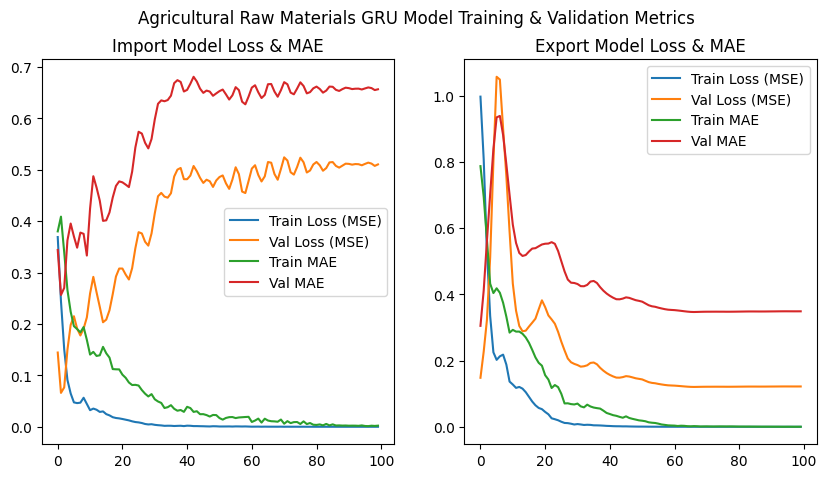

{'Imp_MAE': 0.65654456615448,
 'Imp_MSE': 0.5104210376739502,
 'Exp_MAE': 0.3489925265312195,
 'Exp_MSE': 0.12184733152389526}

In [74]:
run_gru_model("Agricultural Raw Materials")

In [ ]:
run_gru_model("Consumer Goods")

In [ ]:
run_gru_model("Transportation")

................ Training GRU on : Food Industry ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 654ms/step - loss: 0.8216 - mae: 0.6190 - val_loss: 0.5759 - val_mae: 0.5935
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.9974 - mae: 0.7312 - val_loss: 0.1488 - val_mae: 0.3068
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.5032 - mae: 0.5062 - val_loss: 0.0218 - val_mae: 0.1217
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1773 - mae: 0.3201 - val_loss: 0.0819 - val_mae: 0.2788
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1921 - mae: 0.3442 - val_loss: 0.2600 - val_mae: 0.4594
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2307 - mae: 0.4067 - val_loss: 0.2943 - val_mae: 0.4473
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1817 - mae: 0.3540 - val_loss: 0.2496 - val_mae: 0.3788
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1116 - mae: 0.2778 - val_loss: 0.1744 - val_mae: 0.3038
Epo

GRU Import Model Test MAE: 0.4251, MSE: 0.3233
GRU Export Model Test MAE: 0.3733, MSE: 0.1691


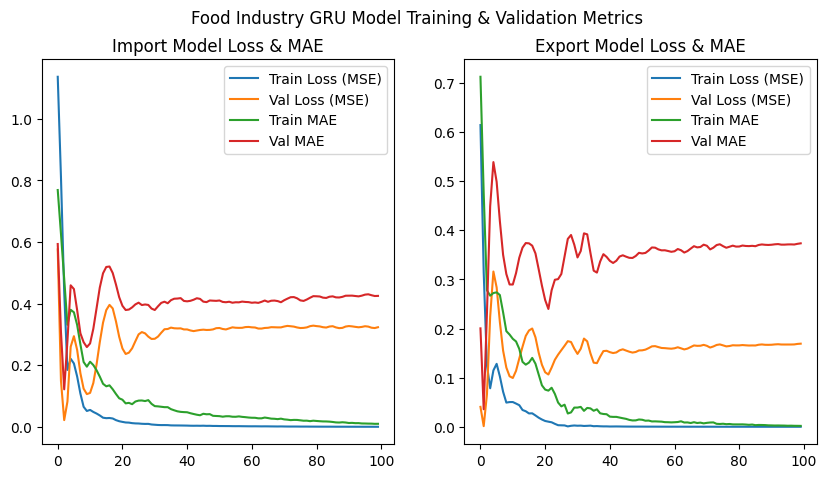

{'Imp_MAE': 0.4250856041908264,
 'Imp_MSE': 0.32334470748901367,
 'Exp_MAE': 0.3733366131782532,
 'Exp_MSE': 0.16912642121315002}

In [75]:
run_gru_model("Food Industry")

In [ ]:
run_gru_model("Capital Goods")

**Model Comparison**

In [87]:
def compare_models(arima_results, lstm_results, gru_results, industry):
    print(f"\n==== Model Comparison for {industry} ====\n")
    print("{:<15} {:<12} {:<12} {:<12} {:<12}".format("Model", "Type", "MAE", "MSE", "RMSE"))

    def rmse(mse): return np.sqrt(mse)

    # Helper to print nicely
    def print_row(model_name, typ, mae, mse):
        print("{:<15} {:<12} {:.4f}      {:.4f}      {:.4f}".format(
            model_name, typ, mae, mse, rmse(mse)))

    print_row("ARIMA", "Import", arima_results["Imp_MAE"], arima_results["Imp_MSE"])
    print_row("ARIMA", "Export", arima_results["Exp_MAE"], arima_results["Exp_MSE"])

    print_row("LSTM", "Import", lstm_results["imp_mae"], lstm_results["imp_mse"])
    print_row("LSTM", "Export", lstm_results["exp_mae"], lstm_results["exp_mse"])

    print_row("GRU", "Import", gru_results["imp_mae"], gru_results["imp_mse"])
    print_row("GRU", "Export", gru_results["exp_mae"], gru_results["exp_mse"])

In [77]:
def build_ts_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.GRU(128, return_sequences=True),
                                        tf.keras.layers.GRU(128),
                                        tf.keras.layers.Dense(1)
                                        ])

    model.compile(
                loss='mse',
                optimizer='adam',
                metrics=['mae']
                )
    return model

def train_ts_model(
                    industry,
                    epochs=100,
                    batch_size=4
                    ):
    X, Y1, Y2 = make_ts_dataset(industry)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
                                X,
                                Y1,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    history_exp = model_exp.fit(
                                X,
                                Y2,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    return history_imp, history_exp

def plot_loss(
            industry,
            history_imp,
            history_exp
            ):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mae'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mae'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw Materials ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.4576 - mae: 0.4667
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2298 - mae: 0.4021
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2164 - mae: 0.4112
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1585 - mae: 0.3334
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1167 - mae: 0.2836
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1671 - mae: 0.3199
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1185 - mae: 0.2700
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0563 - mae: 0.1980
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0623 - mae: 0.2036
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0769 - mae: 0.2117
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0644 - mae: 0.2037
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - l

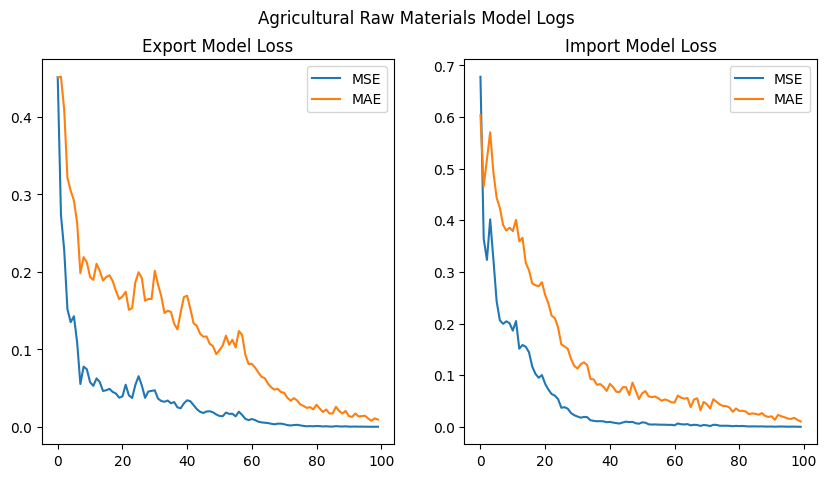

In [78]:
run_ts_model('Agricultural Raw Materials')

................ Training on : Consumer Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.4428 - mae: 0.5775
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2187 - mae: 0.4004
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2218 - mae: 0.3783
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1307 - mae: 0.2956
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0817 - mae: 0.2077
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1030 - mae: 0.2910
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1100 - mae: 0.2957
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1091 - mae: 0.3085
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0915 - mae: 0.2707
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0759 - mae: 0.2372
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0602 - mae: 0.1976
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0601 

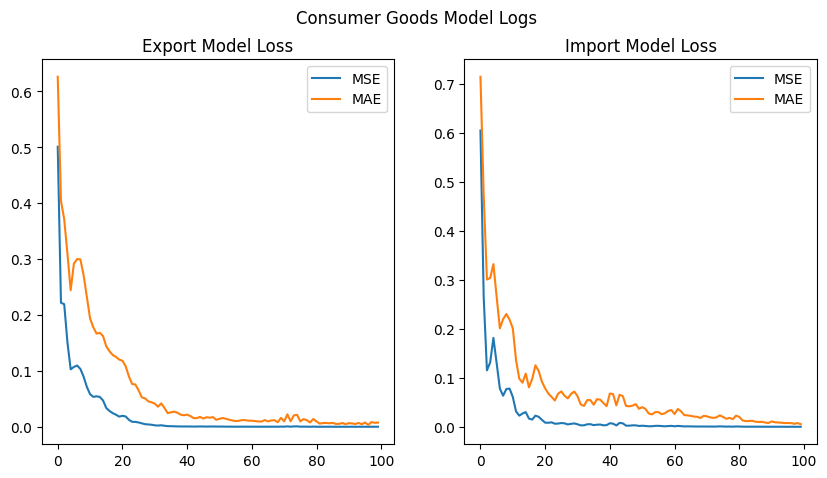

In [79]:
run_ts_model('Consumer Goods')

................ Training on : Transportation ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.4734 - mae: 0.7960
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3301 - mae: 0.8964
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1020 - mae: 0.8392
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9534 - mae: 0.8223
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6368 - mae: 0.6338
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9174 - mae: 0.7426
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6765 - mae: 0.6381
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8560 - mae: 0.6960
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5728 - mae: 0.6028
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6749 - mae: 0.6484
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6615 - mae: 0.6747
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6042 

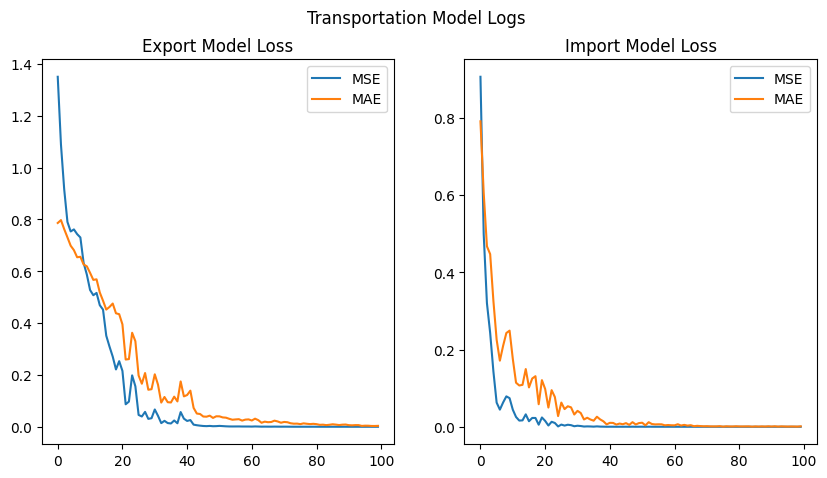

In [80]:
run_ts_model('Transportation')

................ Training on : Food Industry ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 1.3139 - mae: 0.8508
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3113 - mae: 0.4488
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1470 - mae: 0.3267
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1581 - mae: 0.2988
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1551 - mae: 0.3293
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0902 - mae: 0.2539
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0901 - mae: 0.2680
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0913 - mae: 0.2754
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0727 - mae: 0.2357
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0705 - mae: 0.2252
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0607 - mae: 0.1994
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0502 -

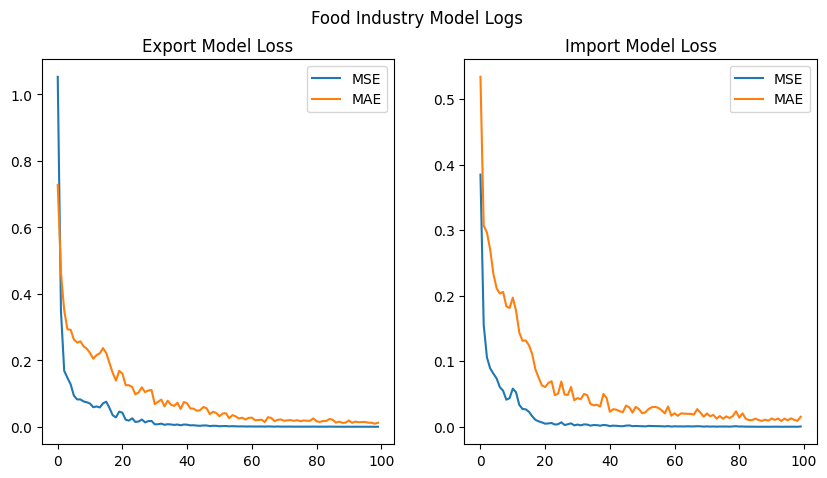

In [81]:
run_ts_model('Food Industry')

................ Training on : Capital Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8417 - mae: 0.7210
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3326 - mae: 0.5145
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2824 - mae: 0.4484
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2763 - mae: 0.4698
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2688 - mae: 0.4474
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2787 - mae: 0.4489
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2330 - mae: 0.3978
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2226 - mae: 0.4002
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1962 - mae: 0.3676
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2317 - mae: 0.4002
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1923 - mae: 0.3815
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2048 -

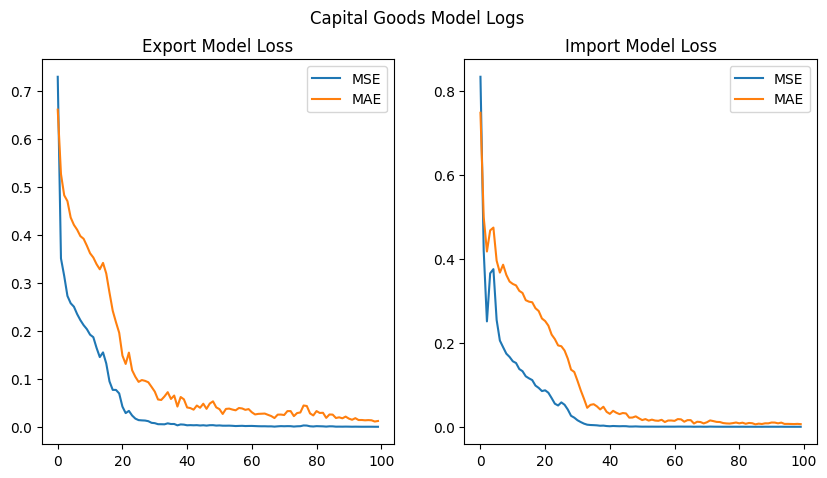

In [82]:
run_ts_model('Capital Goods')

## Inference

In [83]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [84]:
def predict_ts_on_industry(
                            industry,
                            selective_window=7
                            ):
    industry_dict = model_dict[industry]
    scaler = industry_dict['Scaler']
    imp_model = industry_dict['Imp Model']
    exp_model = industry_dict['Exp Model']

    df = load_industry_data(industry)
    df_tail = df.tail(selective_window)

    x = df_tail.values
    x = x.reshape(1, x.shape[0], x.shape[1])

    p_imp = imp_model.predict(x).squeeze()
    p_imp = np.vstack([p_imp]*selective_window).squeeze()
    p_imp = np.dstack([p_imp]*selective_window).squeeze()
    p_imp = scaler.inverse_transform(p_imp)
    p_imp = p_imp[0][0]

    p_exp = exp_model.predict(x).squeeze()
    p_exp = np.vstack([p_exp]*selective_window).squeeze()
    p_exp = np.dstack([p_exp]*selective_window).squeeze()
    p_exp = scaler.inverse_transform(p_exp)
    p_exp = p_exp[0][0]

    df_tail_inv = scaler.inverse_transform(df_tail)
    imp_data = df_tail_inv[:, 0]
    exp_data = df_tail_inv[:, 1]

    avg_imp = np.mean(imp_data)
    avg_exp = np.mean(exp_data)

    # percentage of change
    p_imp = ((p_imp - avg_imp) / avg_imp) * 100
    p_exp = ((p_exp - avg_exp) / avg_exp) * 100

    return p_imp, p_exp

In [85]:
p_imp, p_exp = predict_ts_on_industry('Agricultural Raw Materials')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Predicted Export Change : 20.54%
Predicted Import Change : 10.55%
